## Exercise in Photogrammetry II
# Ex. 05 Bundle Adjustment II
### Submission: 22.01.2021 
### Points: 21


In this exercise you need to compute the bundle adjustment described in the lecture.
You're given the initial guess of the position of *four identical calibrated cameras* as well as *eight object points*, where each point is observed in each camera. Apart from that no further observations were made.
Assume the rotation matrices $R_j$ to be given with $R_j=I_3$. 
Therefore the rotations $\kappa, \theta, \omega$ are not included as unknowns in the bundle adjustment.
Furthermore assume all cameras to be *euclidian cameras*.

The file `data.mat` contains the calibration matrix `K`, initial estimations of the projection centers `camX_pos`, initial estimations of the object points `X` as well as observed image coordinates `camX_obs`, where the i'th observation corresponds to the i'th object.


**Tasks:**

1. Construct the initial parameter vector $\textbf{p}^{(0)}$ and vector of observations $\textbf{l}$. Which size would have the parameter vectors $\mathbf{\Delta k}$ and $\mathbf{\Delta t}$ from the lecture. (2 Points)
2. Given the initial parameters compute the approximated observations $\mathbf{l}^{(0)}.$
	Print out the computed euclidean image coordinates of the first point in each camera to the terminal. (5 Points)
3. 	Construct the coefficient matrix $\mathbf{A}^{(0)}$ given the initial parameters. Visualize the coefficient matrix by using `spy(...)` from matplotlib. The sub-matrices shown in the lecture are given by (10 Points):
\begin{eqnarray}
   B_{ij} &=& \frac{c}{\Delta Z_{ij}}
  \left[ \begin{array}{ccc}
    -1 &  0 & \frac{\Delta X_{ij}}{\Delta Z_{ij}} \\
     0 & -1 & \frac{\Delta Y_{ij} }{ \Delta Z_{ij}} \\
  \end{array}\right]
  \end{eqnarray}

 \begin{eqnarray}
  C_{ij} &=& \frac{c}{\Delta Z_{ij}}
  \left[ \begin{array}{ccc}
    1 & 0 & \frac{-\Delta X_{ij} }{ \Delta Z_{ij}} \\
    0 & 1 & \frac{-\Delta Y_{ij} }{ \Delta Z_{ij}} \\
  \end{array}\right]
  \end{eqnarray}
4. Solve the normal equations $\hat{\mathbf p}=\mathbf{p}^{(0)}+(\mathbf{A}^T \mathbf{A})^{+} \mathbf{A}^T (\mathbf{l}-\mathbf{l}^{(0)})$.
	We assume uniform uncertainty in the image coordinates without any correlation.
	**Note:** $\mathbf{A}^{+}$ denotes the pseudoinverse of the matrix $\mathbf{A}$. (1 Point)  
5. Visualize the initial and estimated parameters. Different parameters should've different colours. (3 Points)

**Note:** $\Delta X_{ij}= X_{i}-X_{0j}$, with  $X_i$= x-Coordinate of i'th object point, $X_{0j}$= x-Coordinate of projection center of j'th camera. $\Delta Y_{ij}$, $\Delta Z_{ij}$ analogue to this.

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

## Load data

In [2]:
data = scipy.io.loadmat('data/data.mat')

# Calibration matrix
K = data['K'].astype(np.float32)
c = K[0, 0]

# initial point coordinates
X = data['X0'].astype(np.float32) # [3 x 8]

# observations and initial projection centers
cameras = data['camera']
cam0_pos = cameras[0,0][0].astype(np.float32) # projection center [3 x 1]
cam0_obs = cameras[0,0][1].astype(np.float32) # observations [2 x 8]
cam1_pos = cameras[1,0][0].astype(np.float32)
cam1_obs = cameras[1,0][1].astype(np.float32)
cam2_pos = cameras[2,0][0].astype(np.float32)
cam2_obs = cameras[2,0][1].astype(np.float32)
cam3_pos = cameras[3,0][0].astype(np.float32)
cam3_obs = cameras[3,0][1].astype(np.float32)
cam_poses = np.hstack((cam0_pos, cam1_pos, cam2_pos, cam3_pos))

In [3]:
print(K) # Calibration matrix.

[[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0.   1.]]


In [4]:
print(X) # Initial estimations of the points in 3D world.

[[0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]]


In [5]:
print(cam_poses) # Initial estimation of the camera locations.

[[0. 0. 1. 1.]
 [0. 1. 0. 1.]
 [3. 3. 3. 3.]]


In [6]:
print(cam0_obs) # 2D Points observed in camera0.

[[ -3.9517994   -2.3149953   -0.27007562  -4.635817   -37.934578
  -44.63949    -28.700468   -47.3615    ]
 [ -0.33381328   6.5078564  -37.373585   -38.137196     3.896591
    2.9845006  -34.31259    -44.73721   ]]


In [7]:
# Task 1.
# Construct initial parameters vector p_0.
# delta_k would be 24x1, delta_t would be 12x1. In total 36 elements lined up vertically. 
# https://youtu.be/LKDLcKrWOIU?si=2E705VXtrFqyT1EJ&t=950 15:50.

X_flat = X.T.flatten()
cam_poses_flat = cam_poses.T.flatten()

p_0 = np.hstack((X_flat, cam_poses_flat)).reshape(-1, 1)
print(p_0.shape)

# Construct the vector of observations l.
l = np.hstack((cam0_obs, cam1_obs, cam2_obs, cam3_obs)).T.reshape(-1, 1)
print(l.shape)

(36, 1)
(64, 1)


In [8]:
# Task 2.
# Compute the approximated observations l_0.
def compute_obs(calibration, parameters, points_num=8):

    # Allocate space for new observations.
    points2d = np.empty((2, 0))

    # Create points matrix from the input parameters Nx1.
    points = parameters[:3*points_num]
    points = np.reshape(points, (-1, 3)).T

    # Create cameras extrinsics from the input parameters Nx1.
    cameras = parameters[3*points_num:]
    cameras = np.reshape(cameras, (-1, 3)).T

    # Add homogeneous coordinate to the points matrix.
    points = np.vstack((points, np.ones((1, points.shape[1]))))

    # Append points for every camera.
    for j in range(cameras.shape[1]):
        
        # Construct a projection matrix 3x4 using this camera's extrinsics.
        P = np.hstack((calibration, -cameras[:, j].reshape(-1, 1)))

        # Transform input points to the j-th camera image frame.
        camera_points = P @ points
        camera_points = camera_points[:2] / camera_points[2] # Back to euclidean.

        # Keep adding points from j-th camera.
        points2d = np.concatenate((points2d, camera_points), axis=1)
    
    return points2d.T.reshape(-1, 1) # Nx1.

l_0 = compute_obs(K, p_0)

# Get first point in each camera.
num_cameras = 4
num_points = 8
for j in range(num_cameras):
    print(l_0[j*num_points*2:j*num_points*2+2])

# Get shape of observations matrix.
print(l_0.shape)

[[-0.]
 [-0.]]
[[-0.        ]
 [ 0.33333333]]
[[ 0.33333333]
 [-0.        ]]
[[0.33333333]
 [0.33333333]]
(64, 1)


In [9]:
# Create cost function.
def compute_cost(observed_points, estimated_points):

    # Shapes must match.
    if observed_points.shape != estimated_points.shape:
        return -1.0

    # Convert the 1-D arrays to 2-D.
    obs_2d = observed_points.reshape(-1, 2)
    est_2d = estimated_points.reshape(-1, 2)

    # Find the distances.
    norms_squared = np.linalg.norm(obs_2d - est_2d, axis=0) ** 2

    # Sum up.
    return np.sum(norms_squared)

cost = compute_cost(l, l_0)

# What is the initial cost (initial estimates vs observations).
print(cost)

62583.086077229076


(64, 36)


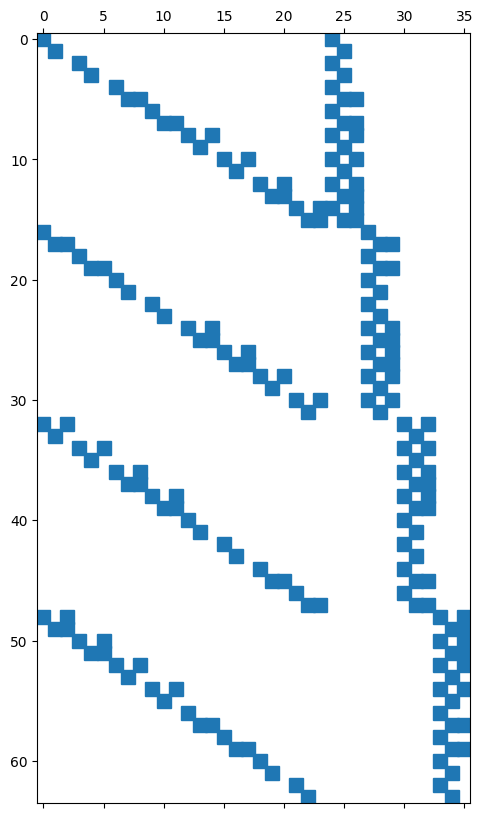

In [10]:
# Task 3.
# Construct the coefficients matrix A.
# According to the lecture this isn't usually computed directly.
# https://youtu.be/LKDLcKrWOIU?si=1NYSWe4HkTwmz31K&t=1192 19:52
def construct_coeff(calibration, parameters, points_num=8):

    # C_ij & B_ij shape is 2x3.

    # Create points matrix from the input parameters Nx1.
    points = parameters[:3*points_num]
    points = np.reshape(points, (-1, 3)).T

    # Create cameras extrinsics from the input parameters Nx1.
    cameras = parameters[3*points_num:]
    cameras = np.reshape(cameras, (-1, 3)).T

    # Allocate memory for the coefficients sub-matrices.
    C = np.zeros((64, points.shape[1] * 3)) # 64 is the total number of observations. @see previous exercise.
    B = np.zeros((64, cameras.shape[1] * 3))

    # Construct the coefficients.
    c = calibration[0, 0]
    for i in range(points.shape[1]):
        for j in range(cameras.shape[1]):

            delta_x = points[0,i] - cameras[0,j]
            delta_y = points[1,i] - cameras[1,j]
            delta_z = points[2,i] - cameras[2,j]
            
            multiplier = c / delta_z

            # Fill C with C_ij's.
            # Single camera does 16 observations (8points * 2params - x,y).
            C[(j * 16) + (i * 2) : (j * 16) + (i * 2) + 2, i * 3 : (i * 3) + 3] = multiplier * np.array([[1, 0, -delta_x / delta_z], [0, 1, -delta_y / delta_z]])

            # Fill B with B_ij's.
            # Each camera has it's own column for points that it sees.
            B[(i * 2) + (j * 16) : (i * 2) + (j * 16) + 2, j * 3 : (j * 3) + 3] = multiplier * np.array([[-1, 0, delta_x / delta_z], [0, -1, delta_y / delta_z]])

    return np.concatenate((C, B), axis=1)
            

# Create coefficients matrix using only the initial parameters.
A = construct_coeff(K, p_0)
print(A.shape)

# Check the sparsity.
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize = (10, 10))
axs.spy(A, markersize=10)
plt.show()

#### I tried doing the same in the picture below. I used 4 points and 4 cameras. Shape is similar. Note that .spy() shows every non zero element of the matrix, meanwhile I just made a small square whenever I placed $B_{ij}$ or $C_{ij}$.

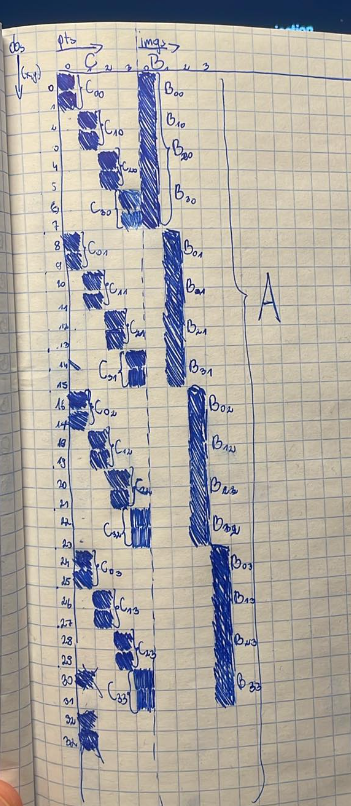

In [21]:
# Task 4.
# Bundle Adjustment using Least Squares.
def bundle_adjustment(K_input, p_0_input, l_input, steps_num=1000, points_num=8):

    # Cache initial parameters.
    p_0 = p_0_input
    l_0 = np.array(())
    
    # Process the least squares.
    for step in range(steps_num):

        # Get new observations Nx1.
        l_0 = compute_obs(K_input, p_0, points_num)

        # Get cost at this step.
        cost = compute_cost(l_input, l_0)

        # Print.
        if step % 100 == 0:
            print(f'iteration {step} : {cost}')

        # Get new coefficients.
        A = construct_coeff(K, p_0, points_num)

        # Update the parameters.
        delta = np.linalg.pinv(A.T @ A) @ A.T @ (l_input - l_0)
        p_0 = p_0 + delta

    return p_0, l_0

In [23]:
est_params, est_obs = bundle_adjustment(K, p_0, l)

iteration 0 : 62583.086077229076
iteration 100 : 7274.797664787389
iteration 200 : 970.3916167694593
iteration 300 : 130.3466080291093
iteration 400 : 17.99252125011113
iteration 500 : 2.9493311619785456
iteration 600 : 0.9348741146611192
iteration 700 : 0.6652525642706343
iteration 800 : 0.629227866541192
iteration 900 : 0.6244380170346973


#### True observations.

In [27]:
print(l.reshape(-1, 2))

[[ -3.9517994   -0.33381328]
 [ -2.3149953    6.5078564 ]
 [ -0.27007562 -37.373585  ]
 [ -4.635817   -38.137196  ]
 [-37.934578     3.896591  ]
 [-44.63949      2.9845006 ]
 [-28.700468   -34.31259   ]
 [-47.3615     -44.73721   ]
 [ -4.240495    32.461533  ]
 [ -2.2227159   60.861942  ]
 [ -0.5538371   -5.5397096 ]
 [ -4.6190042    7.8861747 ]
 [-39.16268     37.27156   ]
 [-46.80451     49.489956  ]
 [-29.69142     -2.7624311 ]
 [-49.94835      5.0024495 ]
 [ 29.06689     -4.610784  ]
 [ 52.692955    -0.27290088]
 [ 33.126835   -42.6417    ]
 [ 43.854744   -45.74337   ]
 [ -5.161207    -0.09932087]
 [  0.6278851   -3.0070155 ]
 [  3.4574225  -39.74458   ]
 [  3.049614   -53.247635  ]
 [ 29.877254    32.335503  ]
 [ 51.35628     57.78913   ]
 [ 33.48931     -2.9857984 ]
 [ 43.505905    10.085862  ]
 [ -1.8298458   36.82815   ]
 [  4.441582    47.57919   ]
 [  6.069829    -0.26502445]
 [  6.8675303    7.903701  ]]


#### Estimated observations.

In [28]:
print(est_obs.reshape(-1, 2))

[[ -4.03070146  -0.32876376]
 [ -2.18673961   6.48272748]
 [ -0.34258595 -37.33595981]
 [ -4.39693789 -38.09336445]
 [-37.89320256   3.90788232]
 [-44.75414771   2.87361714]
 [-28.78687076 -34.38623571]
 [-47.48637983 -44.63954291]
 [ -4.26925733  32.37423043]
 [ -2.49774204  60.81183685]
 [ -0.48106064  -5.52780584]
 [ -4.75781626   7.8951171 ]
 [-39.07571326  37.30497402]
 [-46.66801725  49.38978101]
 [-29.69758773  -2.71524883]
 [-49.73569976   5.12113373]
 [ 29.14258022  -4.51956282]
 [ 52.81864234  -0.11028174]
 [ 33.06376149 -42.67536819]
 [ 43.82238422 -45.86272536]
 [ -5.18488383  -0.22545794]
 [  0.60229651  -2.94048057]
 [  3.52528476 -39.59932124]
 [  2.92370758 -53.41347143]
 [ 29.90618765  32.32288002]
 [ 51.38059472  57.68440712]
 [ 33.55199808  -3.0044429 ]
 [ 43.43715717  10.15784246]
 [ -1.94390439  36.91345178]
 [  4.43702903  47.72965181]
 [  6.09080402  -0.39781878]
 [  6.90046482   7.84834111]]


#### Visualize points accuracy.

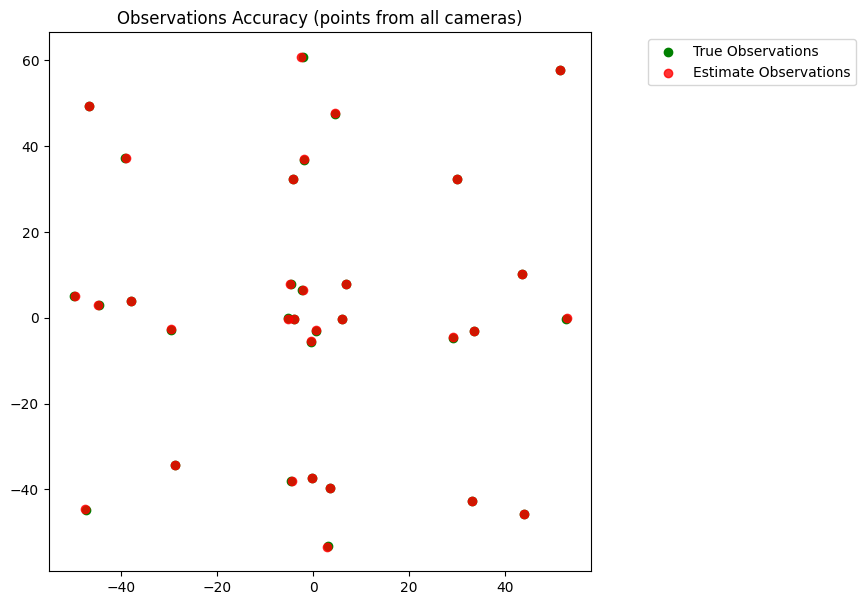

In [112]:
true_obs_2d = l.reshape(-1, 2)
est_obs_2d = est_obs.reshape(-1, 2)

fig, axs = plt.subplots(1, 1, figsize = (7, 7))
axs.scatter(true_obs_2d[:,0], true_obs_2d[:,1], color='green', alpha=1, label='True Observations')
axs.scatter(est_obs_2d[:,0], est_obs_2d[:,1], color='red', alpha=0.8, label='Estimate Observations')

plt.title('Observations Accuracy (points from all cameras)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

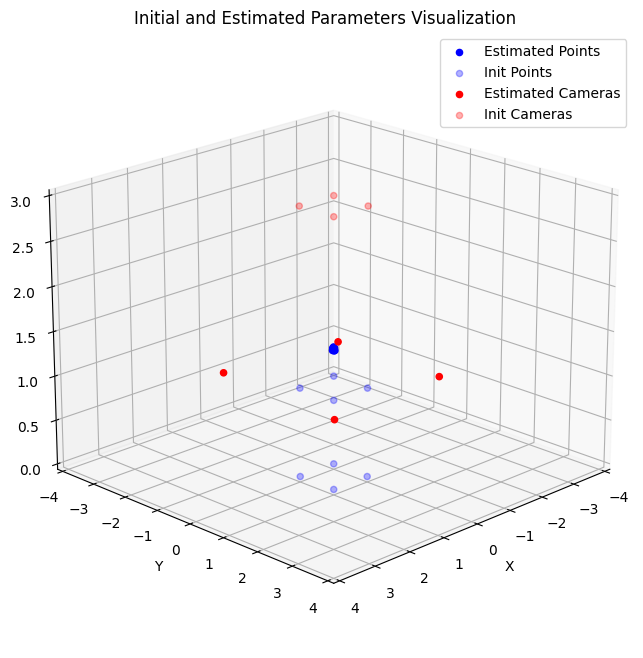

[[ 2.95778002e-03  5.01213431e-04 -4.18884080e-04  2.07353836e-03
   3.33657381e-02  2.84642169e-02  2.56995801e-02  2.72003116e-02]
 [ 8.65385472e-04 -3.08949939e-03  3.46167825e-02  2.48648605e-02
  -2.95190960e-03 -1.31013347e-03  3.21365092e-02  2.68216151e-02]
 [ 1.29262784e+00  1.32778845e+00  1.29294824e+00  1.32036171e+00
   1.29417130e+00  1.31891792e+00  1.29233746e+00  1.32533300e+00]]
[[0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1.]]
[[-0.073134   -0.08459476  2.88408156  3.15380371]
 [ 0.05644832  2.97094655 -0.31486715  3.17551867]
 [ 1.38415334  1.3817236   1.38144297  1.38819416]]
[[0. 0. 1. 1.]
 [0. 1. 0. 1.]
 [3. 3. 3. 3.]]


In [110]:
# Task 5.
# Parameters visualization.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Initial and Estimated Parameters Visualization')

# Create points matrices.
est_points = est_params[:3*8]
est_points = np.reshape(est_points, (-1, 3)).T
init_points = p_0[:3*8]
init_points = np.reshape(init_points, (-1, 3)).T

# Create cameras matrices.
est_cameras = est_params[3*8:]
est_cameras = np.reshape(est_cameras, (-1, 3)).T
init_cameras = p_0[3*8:]
init_cameras = np.reshape(init_cameras, (-1, 3)).T

# Scatter.
ax.scatter(est_points[0, :], est_points[1, :], est_points[2, :], color='blue', alpha=1.0, label='Estimated Points')
ax.scatter(init_points[0, :], init_points[1, :], init_points[2, :], color='blue', alpha=0.3, label='Init Points')
ax.scatter(est_cameras[0, :], est_cameras[1, :], est_cameras[2, :], color='red', alpha=1.0, label='Estimated Cameras')
ax.scatter(init_cameras[0, :], init_cameras[1, :], init_cameras[2, :], color='red', alpha=0.3, label='Init Cameras')

ax.view_init(elev=20, azim=45)

ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.set_zlim(0.0, 3.0)

plt.legend()
plt.show()

print(est_points)
print(init_points)
print(est_cameras)
print(init_cameras)

#### This was pretty hard.